### Setup

In [14]:
import pandas as pd
import numpy as np
from pybiomart import Server
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge

### Load Embeddings and HPO annotations

In [4]:
# Load Embeddings (X)
# index = ensemble ID
X_log = pd.read_csv('data/omics_embedding/OMICS_EMB_log_sigma.tsv', sep="\t" ,index_col=0) 
X_org = pd.read_csv('data/omics_embedding/OMICS_EMB.tsv', sep="\t" ,index_col=0)
# Load HPO Annotations (Raw Data)

phenotype = pd.read_csv('data/hpo/phenotype.hpoa', sep='\t', comment='#', header=None, 
                     names=['gene_id', 'gene_symbol', 'hpo_name', 'hpo_id', 'freq', 'disease', 'etc'])

hpo_df = pd.read_csv('data/hpo/genes_to_phenotype.txt', sep='\t', comment='#')

/var/folders/3b/dy6ckr3151511vk8dm2043gh0000gn/T/ipykernel_78914/522221121.py:7: DtypeWarning: Columns (2,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  phenotype = pd.read_csv('data/hpo/phenotype.hpoa', sep='\t', comment='#', header=None,


In [5]:
# get ensembl to ncbi mapping

server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']


print("Querying BioMart...")
mapping_df = dataset.query(attributes=['ensembl_gene_id', 'entrezgene_id'])


print("Columns returned by BioMart:", mapping_df.columns.tolist())


mapping_df.rename(columns={
    'Gene stable ID': 'ensembl_id', 
    'NCBI gene (formerly Entrezgene) ID': 'ncbi_id'
}, inplace=True)


mapping_df = mapping_df.dropna(subset=['ncbi_id'])

mapping_df['ncbi_id'] = mapping_df['ncbi_id'].astype(int).astype(str)

print(mapping_df.head())

Querying BioMart...
Columns returned by BioMart: ['Gene stable ID', 'NCBI gene (formerly Entrezgene) ID']
         ensembl_id    ncbi_id
5   ENSG00000198888       4535
9   ENSG00000198763       4536
15  ENSG00000198804       4512
16  ENSG00000210151  113219467
18  ENSG00000198712       4513


In [6]:
hpo_df['ncbi_gene_id'] = hpo_df['ncbi_gene_id'].astype(str)

# attach Ensembl IDs to HPO data
hpo_mapped = hpo_df.merge(mapping_df, left_on='ncbi_gene_id', right_on='ncbi_id', how='inner')

print(f"Original annotations: {len(hpo_df)}")
print(f"Mapped annotations:   {len(hpo_mapped)}")

Original annotations: 320212
Mapped annotations:   352989


In [7]:
# how many unique Ensembl IDs are associated with each HPO ID
term_counts = hpo_mapped.groupby('hpo_id')['ensembl_id'].nunique()

# at least 20 genes annotated (like in paper)
min_genes = 20
valid_terms = term_counts[term_counts >= min_genes].index


hpo_filtered = hpo_mapped[hpo_mapped['hpo_id'].isin(valid_terms)]

print(f"Filtering criteria: >= {min_genes} genes per term")
print(f"Number of HPO terms remaining: {len(valid_terms)}")


# rows = ensembl IDs, columns = HPO IDs
Y_full = pd.crosstab(hpo_filtered['ensembl_id'], hpo_filtered['hpo_id'])

Y_full = (Y_full > 0).astype(int)

print(f"Y Matrix Shape: {Y_full.shape} (Genes x {Y_full.shape[1]} HPO Terms)")

Filtering criteria: >= 20 genes per term
Number of HPO terms remaining: 2531
Y Matrix Shape: (5752, 2531) (Genes x 2531 HPO Terms)


In [8]:
# find genes present in both datasets
common_genes = X_log.index.intersection(Y_full.index)

X_aligned = X_log.loc[common_genes]
Y_aligned = Y_full.loc[common_genes]

print(f"Final Training Data (transformed): {len(common_genes)} genes")

# original embeddings
common_genes_org = X_org.index.intersection(Y_full.index)


X_aligned_org = X_org.loc[common_genes_org]
Y_aligned = Y_full.loc[common_genes_org]

print(f"Final Training Data (original): {len(common_genes_org)} genes")

Final Training Data (transformed): 5079 genes
Final Training Data (original): 5079 genes


### Ridge Regression

In simple terms, Ridge Regression is Linear Regression with a penalty.

- The Core Idea: Like standard regression, it tries to find a linear equation (a weighted sum of your omics features) that best predicts the target (whether a gene has a specific HPO term).

- The Problem it Solves: Biological data (like gene expression) is often "multicollinear"—meaning many features are correlated (e.g., if Gene A is expressed, Gene B is often expressed too). Standard regression fails or overfits badly on this.

- The "Ridge" Solution: It adds a "penalty" (L2 regularization) to the loss function that shrinks the coefficients of the model towards zero. This prevents any single feature from dominating the prediction just because of noise, making the model more generalizable to new genes.

### OMICS embedding log sigma

In [9]:
# Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = Ridge(alpha=1.0) # standard baseline

results = []

# Cross-Validation Loop
print("Starting 5-fold Cross-Validation...")

for train_idx, test_idx in kf.split(X_aligned):
    # split data
    X_train, X_test = X_aligned.iloc[train_idx], X_aligned.iloc[test_idx]
    Y_train, Y_test = Y_aligned.iloc[train_idx], Y_aligned.iloc[test_idx]
    
    # train
    model.fit(X_train, Y_train)
    
    # Predict continuous scores
    Y_pred = model.predict(X_test)
    
    # Evaluate each HPO term individually
    # We iterate over columns (terms) to calculate AUPRC per term
    for i, hpo_term in enumerate(Y_aligned.columns):
        y_true = Y_test.iloc[:, i]
        y_score = Y_pred[:, i]
        
        # Only calculate score if there is at least one positive example in the test set
        if np.sum(y_true) > 0:
            score = average_precision_score(y_true, y_score)
            results.append(score)

# Final Result
mean_auprc = np.mean(results)

print(f"mean AUPRC: {mean_auprc:.4f}")


Starting 5-fold Cross-Validation...
mean AUPRC: 0.0842


### original omics embedding

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = Ridge(alpha=1.0) # standard baseline

results_org = []

# Cross-Validation Loop
print("Starting 5-fold Cross-Validation...")

for train_idx, test_idx in kf.split(X_aligned):
    # Split data
    X_train, X_test = X_aligned_org.iloc[train_idx], X_aligned_org.iloc[test_idx]
    Y_train, Y_test = Y_aligned.iloc[train_idx], Y_aligned.iloc[test_idx]
    
    # Train 
    model.fit(X_train, Y_train)
    
    # Predict continuous scores
    Y_pred = model.predict(X_test)
    
    # Evaluate each HPO term individually
    # We iterate over columns (terms) to calculate AUPRC per term
    for i, hpo_term in enumerate(Y_aligned.columns):
        y_true = Y_test.iloc[:, i]
        y_score = Y_pred[:, i]
        
        # Only calculate score if there is at least one positive example in the test set
        if np.sum(y_true) > 0:
            score = average_precision_score(y_true, y_score)
            results_org.append(score)


mean_auprc_org = np.mean(results_org)

print(f"mean AUPRC: {mean_auprc_org:.4f}")

Starting 5-fold Cross-Validation...
mean AUPRC: 0.0801


Text(0.5, 1.0, 'Distribution of AUPRC across HPO Terms')

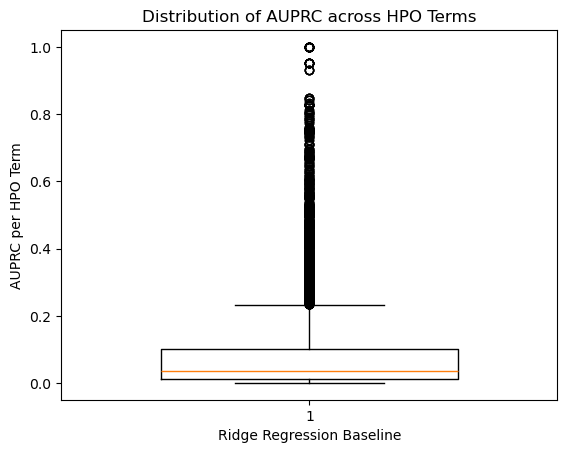

In [15]:
# box plot with results 

plt.boxplot(results, positions=[1], widths=0.6)
plt.xlabel('Ridge Regression Baseline')
plt.ylabel('AUPRC per HPO Term')
plt.title('Distribution of AUPRC across HPO Terms')


In [27]:
from sklearn.linear_model import RidgeClassifier
# RidgeClassifier computes a "decision_function" score which works for AUPRC
# It is extremely fast.

model_rc = RidgeClassifier(class_weight='balanced')

# Loop stays mostly the same, but use decision_function instead of predict_proba
print("Starting RidgeClassifier CV...")

for train_idx, test_idx in kf.split(X_aligned):
    X_train, X_test = X_aligned.iloc[train_idx], X_aligned.iloc[test_idx]
    Y_train, Y_test = Y_aligned.iloc[train_idx], Y_aligned.iloc[test_idx]
    
    # This fits all 2000 targets at once!
    model_rc.fit(X_train, Y_train)
    
    # Get scores (signed distance to hyperplane)
    # This is your "probability-like" score for ranking
    Y_scores = model_rc.decision_function(X_test)
    
    # Evaluate
    for i in range(Y_aligned.shape[1]):
        y_true = Y_test.iloc[:, i]
        y_score = Y_scores[:, i]
        
        if np.sum(y_true) > 0:
            score = average_precision_score(y_true, y_score)
            lr_results.append(score)

print(f"RIDGE CLASSIFIER MEAN AUPRC: {np.mean(lr_results):.4f}")

Starting RidgeClassifier CV...
RIDGE CLASSIFIER MEAN AUPRC: 0.0179
